# 3 layer MNIST

In [55]:
import sys
import numpy as np
import matplotlib.pyplot as plt

from keras.datasets import mnist

In [113]:
plt.rcParams['font.size'] = 18

In [120]:
np.random.seed(3301)

## dataset

In [121]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

In [122]:
images, labels = (x_train[:1000].reshape(1000, 28*28) / 255, y_train[:1000])

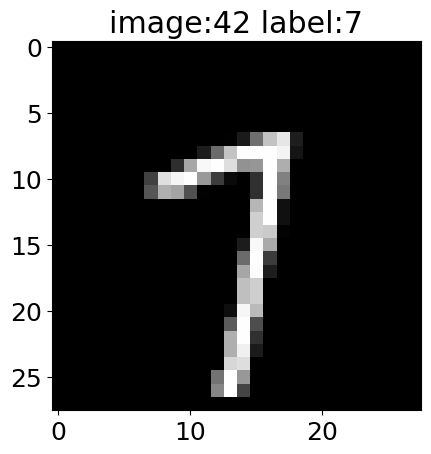

In [124]:
image = 42
fig, ax = plt.subplots()
ax.imshow(x_train[image], cmap='gray')
ax.set_title(f'image:{image} label:{y_train[image]}')

fig.show()

In [63]:
one_hot_labels = np.zeros((len(labels), 10))
for i, l in enumerate(labels):
    one_hot_labels[i][l] = 1

labels = one_hot_labels

In [64]:
test_images = x_test.reshape((len(x_test), 28*28)) / 255

In [65]:
test_labels = np.zeros((len(y_test), 10))
for i, l in enumerate(y_test):
    test_labels[i][l] = 1

## overfitting neural network

In [77]:
relu = lambda x: (x>=0) * x
relu2deriv = lambda x: x>=0

In [78]:
alpha = 0.005
iterations = 1000
hidden_size = 40
pixels_per_image = 784
num_labels = 10

In [86]:
# initialize nn
weights_0_1 = 0.2 * np.random.random((pixels_per_image, hidden_size)) - 0.1
weights_1_2 = 0.2 * np.random.random((hidden_size, num_labels)) - 0.1

In [87]:
# fit train data
for j in range(iterations):
    error, correct_cnt = 0, 0

    for i in range(len(images)):
        layer_0 = images[i:i+1]
        layer_1 = relu(np.dot(layer_0, weights_0_1))
        layer_2 = np.dot(layer_1, weights_1_2)

        error += np.sum((labels[i:i+1] - layer_2) ** 2)
        correct_cnt += int(np.argmax(layer_2) == np.argmax(labels[i:i+1]))

        layer_2_delta = (labels[i:i+1] - layer_2)
        layer_1_delta = layer_2_delta.dot(weights_1_2.T) * relu2deriv(layer_1)

        weights_1_2 += alpha * layer_1.T.dot(layer_2_delta)
        weights_0_1 += alpha * layer_0.T.dot(layer_1_delta)

    sys.stdout.write(f'\r I:{j} Error: {error/float(len(images)):0.5f} Correct: {correct_cnt/float(len(images))}')

 I:999 Error: 0.08492 Correct: 0.999

In [89]:
# test data
error, correct_cnt = 0, 0
for i in range(len(test_images)):
    layer_0 = test_images[i:i+1]
    layer_1 = relu(np.dot(layer_0, weights_0_1))
    layer_2 = np.dot(layer_1, weights_1_2)

    error += np.sum((test_labels[i:i+1] - layer_2) ** 2)
    correct_cnt += int(np.argmax(layer_2) == np.argmax(test_labels[i:i+1]))


sys.stdout.write(f'\r Error: {error/float(len(test_images)):0.5f} Correct: {correct_cnt/float(len(test_images))}')


 Error: 0.75557 Correct: 0.6557

Soooo train data was fitted perfectly but when evaluating on test (unseen) data the network performed terribly. Let's profile train and test errors over iterations...

In [100]:
# (re)initialize nn
weights_0_1 = 0.2 * np.random.random((pixels_per_image, hidden_size)) - 0.1
weights_1_2 = 0.2 * np.random.random((hidden_size, num_labels)) - 0.1

In [101]:
# fit train data
train_errors = []
train_correct_cnts = []

test_errors = []
test_correct_cnts = []

for j in range(iterations):
    error, correct_cnt = 0, 0

    for i in range(len(images)):
        layer_0 = images[i:i+1]
        layer_1 = relu(np.dot(layer_0, weights_0_1))
        layer_2 = np.dot(layer_1, weights_1_2)

        error += np.sum((labels[i:i+1] - layer_2) ** 2)
        correct_cnt += int(np.argmax(layer_2) == np.argmax(labels[i:i+1]))

        layer_2_delta = (labels[i:i+1] - layer_2)
        layer_1_delta = layer_2_delta.dot(weights_1_2.T) * relu2deriv(layer_1)

        weights_1_2 += alpha * layer_1.T.dot(layer_2_delta)
        weights_0_1 += alpha * layer_0.T.dot(layer_1_delta)

    train_errors.append(error)
    train_correct_cnts.append(correct_cnt)


    sys.stdout.write(f'\r I:{j} Error: {error/float(len(images)):0.5f} Correct: {correct_cnt/float(len(images))}')

    test_error, test_correct_cnt = 0, 0
    for k in range(len(test_images)):
        layer_0 = test_images[k:k+1]
        layer_1 = relu(np.dot(layer_0, weights_0_1))
        layer_2 = np.dot(layer_1, weights_1_2)

        test_error += np.sum((test_labels[k:k+1] - layer_2) ** 2)
        test_correct_cnt += int(np.argmax(layer_2) == np.argmax(test_labels[k:k+1]))

    test_errors.append(test_error)
    test_correct_cnts.append(test_correct_cnt)

 I:999 Error: 0.08274 Correct: 1.0

In [103]:
train_acc = [i/len(images) for i in train_correct_cnts]
test_acc = [i/len(test_images) for i in test_correct_cnts]

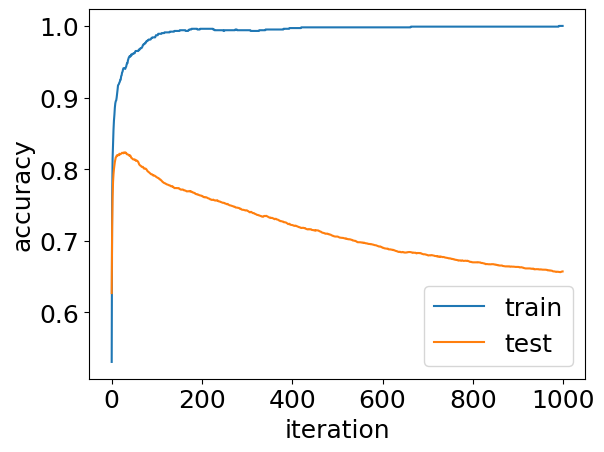

In [114]:
fig, ax = plt.subplots()
ax.plot(train_acc, label='train')
ax.plot(test_acc, label='test')

ax.set_xlabel('iteration')
ax.set_ylabel('accuracy')

ax.legend()
fig.show()

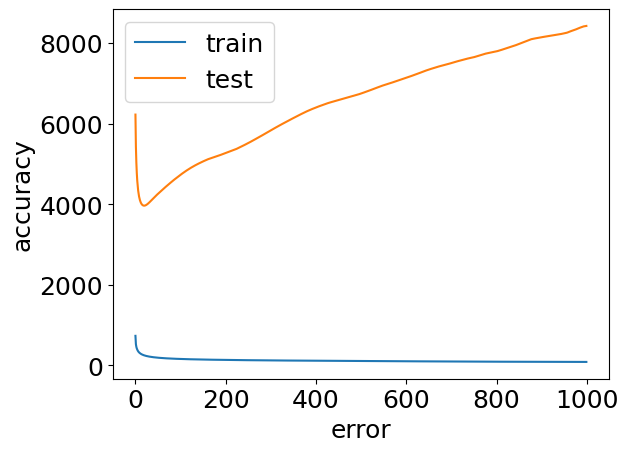

In [118]:
fig, ax = plt.subplots()

ax.plot(train_errors, label='train')
ax.plot(test_errors, label='test')

ax.set_xlabel('error')
ax.set_ylabel('accuracy')

ax.legend()
fig.show()

## Regularization using dropout